# Week 03 - Combining Tables for Translational Analysis 

**Focus:** Merging experimental readouts with compound metadata to enable mechanism- and target-level analysis. 

**Skills practiced:**
- Loading multiple CSV files
- Inspecting table structure before merging
- Merging datasets using 'pd.merge()'
- Understanding join keys and merge types
- Grouping data using 'groupby()'
- Writing simple, reusable helper functions
- Reshaping dat from wide to long using 'pd.melt()'

**Biological context:**
In translational screening workflows, phenotypic readouts are often stored separately from compound annotations such as mechanism of action or target class. Integrating these sources enables higher-level interpretation and supports decision-making in compound prioritization. 

## Day 1 - Combining Phenotype Data with Compound Metadata

## 1. Data loading and inspection 

In [3]:
import pandas as pd

phenotype_df = pd.read_csv("data/phenotype_results.csv")
metadata_df = pd.read_csv("data/compound_metadata.csv")

print(phenotype_df.head())
print(metadata_df.head())

  sample_id compound  dose  phenotype_score
0        S1     DMSO     0             0.01
1        S2     DMSO     0             0.00
2        S3   Cmpd_A     1             0.55
3        S4   Cmpd_A     2             0.82
4        S5   Cmpd_B     1             0.24
  compound    target   mechanism
0     DMSO       NaN     vehicle
1   Cmpd_A  Target_X     agonist
2   Cmpd_B  Target_Y  antagonist


## 2. Combine phenotype data with compound metadata

In [4]:
merged_df = phenotype_df.merge(
    metadata_df, 
    on="compound",
    how="left"
)

print(merged_df)

  sample_id compound  dose  phenotype_score    target   mechanism
0        S1     DMSO     0             0.01       NaN     vehicle
1        S2     DMSO     0             0.00       NaN     vehicle
2        S3   Cmpd_A     1             0.55  Target_X     agonist
3        S4   Cmpd_A     2             0.82  Target_X     agonist
4        S5   Cmpd_B     1             0.24  Target_Y  antagonist
5        S6   Cmpd_B     2             0.38  Target_Y  antagonist


## 3. Exploratory summaries by biological annotation

In [5]:
# Mean phenotype score by mechanism 

mechanism_means = merged_df.groupby("mechanism")["phenotype_score"].mean()
print(mechanism_means)

mechanism
agonist       0.685
antagonist    0.310
vehicle       0.005
Name: phenotype_score, dtype: float64


In [8]:
# Mean phenotype score by compound 
compound_means = merged_df.groupby("compound")["phenotype_score"].mean()
print(compound_means)

compound
Cmpd_A    0.685
Cmpd_B    0.310
DMSO      0.005
Name: phenotype_score, dtype: float64


In [9]:
print("phenotype rows:", len(phenotype_df))

phenotype rows: 6


In [10]:
print("merged rows:", len(merged_df))

merged rows: 6


In [12]:
print("missing mechanism:", merged_df["mechanism"].isna().sum())

missing mechanism: 0


## 4. Traslational interpretation

- **Top mechanism (by mean phenotype score):** Agonist
- **What this suggests:** Agonist compounds show the highest score compared to antagonist compounds and vehicle, indicating pathway activation is associated with a stronger phenotypic response in this assay. 
- **Caveat:** This is a small illustrative dataset; in real screening data, additional checks such as replicate consistency, batch effects, and dose-response trends would be required before prioritizing a mechanism. 

## Day 2 - Reshaping Data for Dose-Response Analysis

In [2]:
import pandas as pd

wide_df = pd.read_csv("data/phenotype_wide.csv")
print(wide_df)

  compound  dose_1  dose_2
0   Cmpd_A    0.55    0.82
1   Cmpd_B    0.24    0.38


**In-line**

In [3]:
# Convert wide-format data to long format 

long_df = pd.melt(
    wide_df, 
    id_vars="compound",
    value_vars=["dose_1", "dose_2"],
    var_name="dose",
    value_name="phenotype_score"
)
print(long_df)

  compound    dose  phenotype_score
0   Cmpd_A  dose_1             0.55
1   Cmpd_B  dose_1             0.24
2   Cmpd_A  dose_2             0.82
3   Cmpd_B  dose_2             0.38


In [4]:
# Extract numeric dose from column name

long_df["dose"] = long_df["dose"].str.replace("dose_", "").astype(int)

print(long_df)

  compound  dose  phenotype_score
0   Cmpd_A     1             0.55
1   Cmpd_B     1             0.24
2   Cmpd_A     2             0.82
3   Cmpd_B     2             0.38


In [5]:
# Mean phenotype score by compound and dose

long_df.groupby(["compound", "dose"])["phenotype_score"].mean()

compound  dose
Cmpd_A    1       0.55
          2       0.82
Cmpd_B    1       0.24
          2       0.38
Name: phenotype_score, dtype: float64

**Function**

In [6]:
def wide_to_long(data):
    long_data = pd.melt(
        data, 
        id_vars="compound",
        var_name="dose",
        value_name="phenotype_score"
    )
    long_data["dose"] = long_data["dose"].str.replace("dose_", "").astype(int)
    return long_data

In [7]:
wide_to_long(wide_df)

,compound,dose,phenotype_score
0,Cmpd_A,1,0.55
1,Cmpd_B,1,0.24
2,Cmpd_A,2,0.82
3,Cmpd_B,2,0.38


## Translational interpretation 

Reshaping wide-format assay data into long format enables dose-aware analysis and visualization. This structure is required for dose-response modeling, statistical comparisons across doses, and integration with metadata tables in translational workflows. 

In [12]:
# step-by-step melt

# 1) Choose the columns that identify each row (these stay fixed)
id_columns = ["compound"]

# 2) Choose the columns that contain the values tho stack into rows
dose_columns = ["dose_1", "dose_2"]

# 3) Melt (reshape) wide -> long
long_df = pd.melt(
    wide_df, 
    id_vars=id_columns,
    value_vars=dose_columns,
    var_name="dose",
    value_name="phenotype_score"
)
print(long_df)


  compound    dose  phenotype_score
0   Cmpd_A  dose_1             0.55
1   Cmpd_B  dose_1             0.24
2   Cmpd_A  dose_2             0.82
3   Cmpd_B  dose_2             0.38


In [13]:
# step-by-step dose cleaning (string->number)

# Look at the unique values currently in the dose column 
print(long_df["dose"].unique())

['dose_1' 'dose_2']


In [14]:
print(long_df.dtypes)

compound            object
dose                object
phenotype_score    float64
dtype: object


In [16]:
# take the dose column as strings 
dose_strings = long_df["dose"]

# remove the prefix "dose_" 
dose_number_strings = dose_strings.str.replace("dose_", "")

print(dose_number_strings.unique())

['1' '2']


In [17]:
# convert "!" -> 1, "2" -> 2
dose_numbers = dose_number_strings.astype(int)

# save back into the dataframe 
long_df["dose"] = dose_numbers

print(long_df.head())

  compound  dose  phenotype_score
0   Cmpd_A     1             0.55
1   Cmpd_B     1             0.24
2   Cmpd_A     2             0.82
3   Cmpd_B     2             0.38


In [18]:
print(long_df.dtypes)

compound            object
dose                 int64
phenotype_score    float64
dtype: object


In [19]:
# check that each compound as one row per dose
print(long_df.groupby(["compound", "dose"]).size())

compound  dose
Cmpd_A    1       1
          2       1
Cmpd_B    1       1
          2       1
dtype: int64


In [21]:
long_df["dose"]=dose_number_strings.astype(int)
print(long_df["dose"].unique())

[1 2]


In [22]:
print(long_df.dtypes)

compound            object
dose                 int64
phenotype_score    float64
dtype: object


## Exploratory visualization (dose-response)

In [23]:
print(long_df.head())

  compound  dose  phenotype_score
0   Cmpd_A     1             0.55
1   Cmpd_B     1             0.24
2   Cmpd_A     2             0.82
3   Cmpd_B     2             0.38


In [24]:
print(long_df.dtypes)

compound            object
dose                 int64
phenotype_score    float64
dtype: object


In [26]:
# Group and compute mean phenotype score for each compound-dose pair 
dose_response_means = (
    long_df
    .groupby(["compound", "dose"])["phenotype_score"]
    .mean()
    .reset_index()
)

print(dose_response_means)

  compound  dose  phenotype_score
0   Cmpd_A     1             0.55
1   Cmpd_A     2             0.82
2   Cmpd_B     1             0.24
3   Cmpd_B     2             0.38


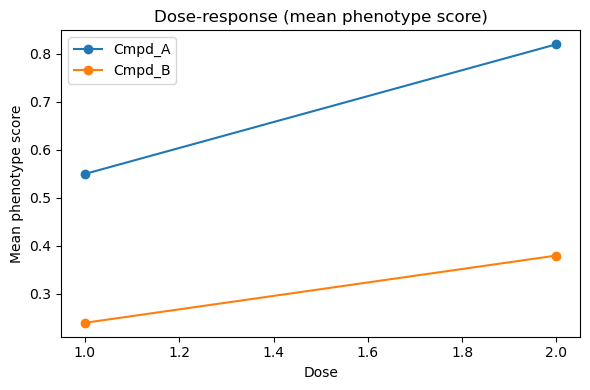

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

# plot one line per compound 
for compound_name in dose_response_means["compound"].unique():
    subset = dose_response_means[dose_response_means["compound"] == compound_name]
    plt.plot(subset["dose"], subset["phenotype_score"], marker = "o", label=compound_name)

plt.title("Dose-response (mean phenotype score)")
plt.xlabel("Dose")
plt.ylabel("Mean phenotype score")
plt.legend()
plt.tight_layout()
plt.show()

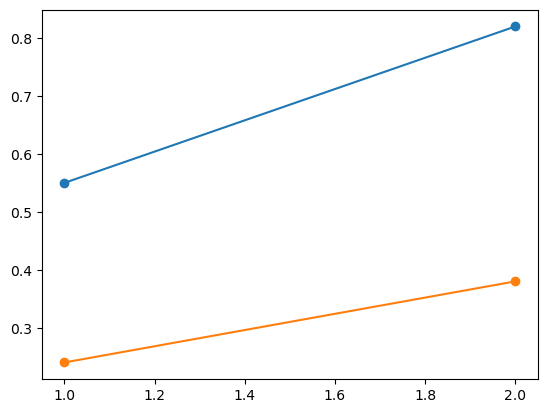

In [29]:
# Get the list of compounds to plot
compound_list = dose_response_means["compound"].unique()

# Loop through each compound 
for compound_name in compound_list:

    # Select rows for the current compound 
    subset = dose_response_means[dose_response_means["compound"] == compound_name]

    # Extract x and y values
    doses = subset["dose"]
    scores = subset["phenotype_score"]

    # Plot the line 
    plt.plot(doses, scores, marker="o", label=compound_name)

## long -> wide using pivot

In [31]:
# Pivot long-format data back to wide format
wide_again = long_df.pivot(
    index="compound",
    columns="dose",
    values="phenotype_score"
)

print(wide_again)

dose         1     2
compound            
Cmpd_A    0.55  0.82
Cmpd_B    0.24  0.38


In [32]:
# Rename dose columns to match original wide format
wide_again.columns = [f"dose_{d}" for d in wide_again.columns]

print(wide_again)

          dose_1  dose_2
compound                
Cmpd_A      0.55    0.82
Cmpd_B      0.24    0.38


In [34]:
wide_again = long_df.pivot(
    index="compound",
    columns="dose",
    values="phenotype_score"
)

# Create an empty list to store new column names
new_column_names = []

# Loop th rough current column names
for column_value in wide_again.columns:

    # Create new column name with prefix
    new_name = "dose_" + str(column_value)

    # Add to list
    new_column_names.append(new_name)

# Replace the dataframe's column names
wide_again.columns = new_column_names

print(wide_again)

          dose_1  dose_2
compound                
Cmpd_A      0.55    0.82
Cmpd_B      0.24    0.38


### Day 2 takeaway 

- Long format (one row per measurement) is preferred for analysis, grouping, and plotting.
- Wide format (one column per condition) is common in raw exports and spreadsheets.
- Being able to convert between formats makes it easier to integrate data from different sources and tools.

In [2]:
import pandas as pd

assay_df = pd.read_csv("data/assay_results.csv")
info_df = pd.read_csv("data/compound_info.csv")

print(assay_df)
print(info_df)

  compound  dose_1  dose_2  dose_3
0       A1    0.10    0.25    0.40
1       B2    0.05    0.07    0.08
2       C3    0.20    0.45    0.90
  compound   mechanism
0       A1     agonist
1       B2     vehicle
2       C3  antagonist


In [3]:
# Step1: Define identifier columns 
# Columns that identify each original row
id_columns = ["compound"]

In [4]:
# Step2: Define value columns 
# Columns that contain dose measurements 
dose_columns = ["dose_1", "dose_2", "dose_3"]

In [7]:
long_df = pd.melt(
    assay_df,
    id_vars=id_columns,
    value_vars=dose_columns,
    var_name="dose",
    value_name="phenotype_score"
)

print(long_df)

  compound    dose  phenotype_score
0       A1  dose_1             0.10
1       B2  dose_1             0.05
2       C3  dose_1             0.20
3       A1  dose_2             0.25
4       B2  dose_2             0.07
5       C3  dose_2             0.45
6       A1  dose_3             0.40
7       B2  dose_3             0.08
8       C3  dose_3             0.90


In [8]:
print(long_df.dtypes)

compound            object
dose                object
phenotype_score    float64
dtype: object


In [10]:
# Confirm what the values look like 
print(long_df["dose"].unique())

['dose_1' 'dose_2' 'dose_3']


In [13]:
# Remove the "dose_" prefix (string cleanup)
dose_strings = long_df["dose"]
dose_number_strings = dose_strings.str.replace("dose_","")

print(dose_number_strings)

0    1
1    1
2    1
3    2
4    2
5    2
6    3
7    3
8    3
Name: dose, dtype: object


In [15]:
# Convert strings -> integers
dose_numbers = dose_number_strings.astype(int)
long_df["dose"] = dose_numbers

print(long_df["dose"].unique())
print(long_df.dtypes)

[1 2 3]
compound            object
dose                 int64
phenotype_score    float64
dtype: object


In [16]:
print(long_df.head())
print(info_df.head())

  compound  dose  phenotype_score
0       A1     1             0.10
1       B2     1             0.05
2       C3     1             0.20
3       A1     2             0.25
4       B2     2             0.07
  compound   mechanism
0       A1     agonist
1       B2     vehicle
2       C3  antagonist


In [17]:
# Merge

merged_df = long_df.merge(
    info_df, 
    on="compound",
    how="left"
)

print(merged_df.head())

  compound  dose  phenotype_score   mechanism
0       A1     1             0.10     agonist
1       B2     1             0.05     vehicle
2       C3     1             0.20  antagonist
3       A1     2             0.25     agonist
4       B2     2             0.07     vehicle


In [18]:
print("assay rows (long_df):", len(long_df))
print("merged rows:", len(merged_df))
print("missing mechanism:", merged_df["mechanism"].isna().sum())

assay rows (long_df): 9
merged rows: 9
missing mechanism: 0


In [19]:
# Group data by mechanism and dose
grouped = merged_df.groupby(["mechanism", "dose"])

# Compute mean phenotype score
mean_scores = grouped["phenotype_score"].mean()

print(mean_scores)

mechanism   dose
agonist     1       0.10
            2       0.25
            3       0.40
antagonist  1       0.20
            2       0.45
            3       0.90
vehicle     1       0.05
            2       0.07
            3       0.08
Name: phenotype_score, dtype: float64


In [20]:
# Reset index so plotting is easier
mean_scores_df = mean_scores.reset_index()
print(mean_scores_df)

    mechanism  dose  phenotype_score
0     agonist     1             0.10
1     agonist     2             0.25
2     agonist     3             0.40
3  antagonist     1             0.20
4  antagonist     2             0.45
5  antagonist     3             0.90
6     vehicle     1             0.05
7     vehicle     2             0.07
8     vehicle     3             0.08


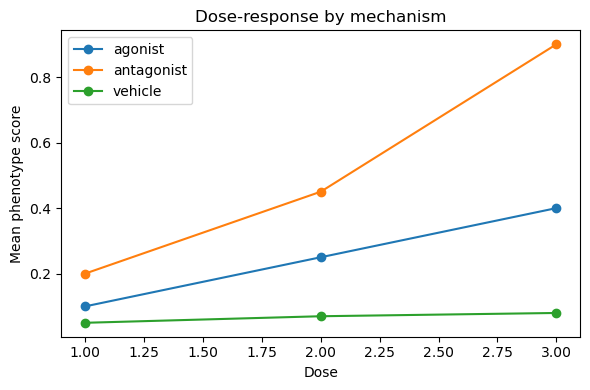

In [21]:
# Plot
import matplotlib.pyplot as plt

# Get list of mechanisms 
mechanism_list = mean_scores_df["mechanism"].unique()

plt.figure(figsize=(6,4))

# Loop through each mechanism 
for mechanism_name in mechanism_list: 

    # Select rows for this mechanism 
    mechanism_data = mean_scores_df[
        mean_scores_df["mechanism"] == mechanism_name
        ]

    # Extract x and y values
    doses = mechanism_data["dose"]
    scores = mechanism_data["phenotype_score"]

    # Plot
    plt.plot(doses, scores, marker="o", label=mechanism_name)

plt.title("Dose-response by mechanism")
plt.xlabel("Dose")
plt.ylabel("Mean phenotype score")
plt.legend()
plt.tight_layout()
plt.show()

## Week 03: Reinforcement Challenge

In [45]:
import pandas as pd

screen_df = pd.read_csv("data/screen_output.csv")
annotation_df = pd.read_csv("data/compound_annotations.csv")

print(screen_df.head())
print(compound_df.head())

  compound_name    D1    D2    D3
0            X1  0.12  0.30  0.55
1            Y2  0.05  0.06  0.08
2            Z3  0.22  0.50  0.95
  compound_name target_class
0            X1      agonist
1            Y2      vehicle
2            Z3   antagonist


In [46]:
print(screen_df.dtypes)
print(annotation_df.dtypes)

compound_name     object
D1               float64
D2               float64
D3               float64
dtype: object
compound_name    object
target_class     object
dtype: object


In [47]:
print(screen_df.columns)

Index(['compound_name', 'D1', 'D2', 'D3'], dtype='object')


In [48]:
screen_df = pd.read_csv("data/screen_output.csv", sep=",")
print(screen_df.head())
print(screen_df.dtypes)

  compound_name    D1    D2    D3
0            X1  0.12  0.30  0.55
1            Y2  0.05  0.06  0.08
2            Z3  0.22  0.50  0.95
compound_name     object
D1               float64
D2               float64
D3               float64
dtype: object


**Important learning moment** 
- when something looks wrong in pandas:
1. check .columns
2. check .head()
3. check .dtypes

In [49]:
id_columns = ["compound_name"]
dose_columns = ["D1", "D2", "D3"]

long_df = pd.melt(
    screen_df,
    id_vars=id_columns,
    value_vars=dose_columns,
    var_name="dose",
    value_name="phenotype_score"
)

print(long_df.head())
print(long_df["dose"].unique())
print(long_df.dtypes)

  compound_name dose  phenotype_score
0            X1   D1             0.12
1            Y2   D1             0.05
2            Z3   D1             0.22
3            X1   D2             0.30
4            Y2   D2             0.06
['D1' 'D2' 'D3']
compound_name       object
dose                object
phenotype_score    float64
dtype: object


In [50]:
print(long_df["dose"].unique())

['D1' 'D2' 'D3']


In [51]:
dose_strings = long_df["dose"]
dose_number_strings = dose_strings.str.replace("D","")

print(dose_number_strings.unique())

['1' '2' '3']


In [52]:
dose_numbers = dose_number_strings.astype(int)
long_df["dose"] = dose_numbers

print(long_df["dose"].unique())
print(long_df.dtypes)

[1 2 3]
compound_name       object
dose                 int64
phenotype_score    float64
dtype: object


In [53]:
print(annotation_df.head())
print(annotation_df.dtypes)

  compound_name target_class
0            X1      agonist
1            Y2      vehicle
2            Z3   antagonist
compound_name    object
target_class     object
dtype: object


In [54]:
merged_df = long_df.merge(
    annotation_df,
    on="compound_name",
    how="left",
)

print(merged_df.head())
print("Number of rows:", len(merged_df))
print("Missing target_class:", merged_df["target_class"].isna().sum())

  compound_name  dose  phenotype_score target_class
0            X1     1             0.12      agonist
1            Y2     1             0.05      vehicle
2            Z3     1             0.22   antagonist
3            X1     2             0.30      agonist
4            Y2     2             0.06      vehicle
Number of rows: 9
Missing target_class: 0


In [55]:
grouped = merged_df.groupby(["target_class", "dose"])

In [56]:
mean_scores = grouped["phenotype_score"].mean()
print(mean_scores)

target_class  dose
agonist       1       0.12
              2       0.30
              3       0.55
antagonist    1       0.22
              2       0.50
              3       0.95
vehicle       1       0.05
              2       0.06
              3       0.08
Name: phenotype_score, dtype: float64


In [57]:
mean_scores_df = mean_scores.reset_index()
print(mean_scores_df)

  target_class  dose  phenotype_score
0      agonist     1             0.12
1      agonist     2             0.30
2      agonist     3             0.55
3   antagonist     1             0.22
4   antagonist     2             0.50
5   antagonist     3             0.95
6      vehicle     1             0.05
7      vehicle     2             0.06
8      vehicle     3             0.08


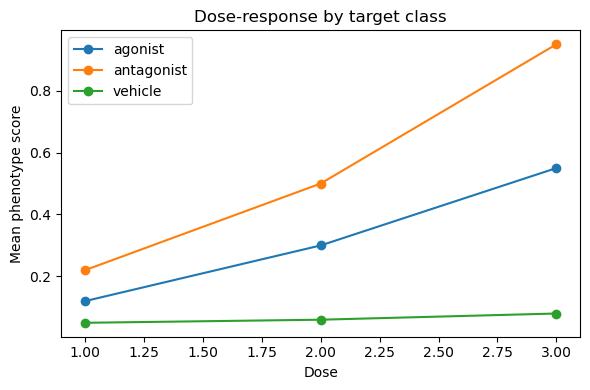

In [58]:
import matplotlib.pyplot as plt

target_classes = mean_scores_df["target_class"].unique()

plt.figure(figsize=(6,4))

for class_name in target_classes:
    class_data = mean_scores_df[
        mean_scores_df["target_class"] == class_name
        ]

    doses = class_data["dose"]
    scores = class_data["phenotype_score"]

    plt.plot(doses, scores, marker="o", label=class_name)

plt.title("Dose-response by target class")
plt.xlabel("Dose")
plt.ylabel("Mean phenotype score")
plt.legend()
plt.tight_layout()
plt.show()